# Introduction
This document outlines the process of building a Predecting Fraudulent Transactions model using a Random Forest classifier and XGBoost, incorporating data preprocessing, feature engineering, hyperparameter tuning, and model evaluation. 

## Data Cleaning

- **Missing Values:** No missing values were found in the dataset.
- **Outliers:** Outliers in numerical features were handled using winsorization to cap extreme values.
- **Multicollinearity:** High correlation between `log_oldbalanceDest` and `log_newbalanceDest` was identified using VIF. `log_oldbalanceDest` was removed to address this.

## Fraud Detection Model

- **XGBoost:** A XGBoost classifier was used as the primary model, demonstrating strong performance in fraud detection.
- **Hyperparameter Tuning:** RandomizedSearchCV was employed to optimize hyperparameters for improved accuracy.
- **Class Imbalance:**
SMOTE was applied to address class imbalance by oversampling the minority class (fraudulent transactions).



## Variable Selection

- **Feature Importance:** The model identified `log_oldbalanceOrg` and `log_amount` as the most significant predictors of fraud.
- **Multicollinearity:** `log_oldbalanceDest` was removed due to its high correlation with `log_newbalanceDest`.

## Model Performance

- **Accuracy:** 0.9996
- **Precision:** 0.7961
- **Recall:** 0.9302
- **F1-score:** 0.8579
- **AUC-ROC:** 0.9649

## Key Factors Predicting Fraud

- **Account Balance Changes:** Changes in account balances, as captured by `log_oldbalanceOrg`, are strong indicators of fraud.
- **Transaction Amounts:** Unusual transaction amounts, as represented by `log_amount`, are also significant predictors.

## Factor Analysis

- The identified factors align with common fraud patterns, making them reasonable predictors.

## Prevention Measures

- **Real-time Monitoring:** Continuously monitor account activity for suspicious patterns.
- **Behavioral Analytics:** Analyze customer behavior to detect anomalies.
- **Education and Awareness:** Educate customers about fraud prevention.
- **Technology-Based Solutions:** Employ advanced fraud detection techniques and update security regularly.

## Determining Effectiveness

- Track fraud rates, false positives, customer satisfaction, and conduct regular audits to evaluate the effectiveness of prevention measures.


## Conclusion
The Random Forest classifier, coupled with data preprocessing and hyperparameter tuning, effectively detected fraudulent transactions in the given dataset.The XGBoost model outperforms the Random Forest model in terms of most metrics, showing higher accuracy, precision, recall, and AUC-ROC score. These metrics indicate that the XGBoost model is highly effective in detecting fraudulent transactions with fewer false positives and false negatives compared to the Random Forest model.The identified key factors, such as account balance changes and transaction amounts, can be used to guide fraud prevention efforts. By implementing the recommended prevention measures, organizations can strengthen their fraud detection capabilities and protect their customers.




***IMPORT NECCESSARY LIBRARIES***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mstats
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.stats.outliers_influence import variance_inflation_factor

***LOAD*** ***DATASET***

In [ ]:
df = pd.read_csv("Fraud.csv")

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [ ]:
df.shape

(6362620, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


***DATA*** ***PREPROCESSING***


*   HandLE Null values
*   Handling Outliers
*   Label Encoding
*   Standardize Features
*   Feature Engineering
*   Handling Multi-Colinearity



In [ ]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
df.duplicated().sum()

0

<function matplotlib.pyplot.show(close=None, block=None)>

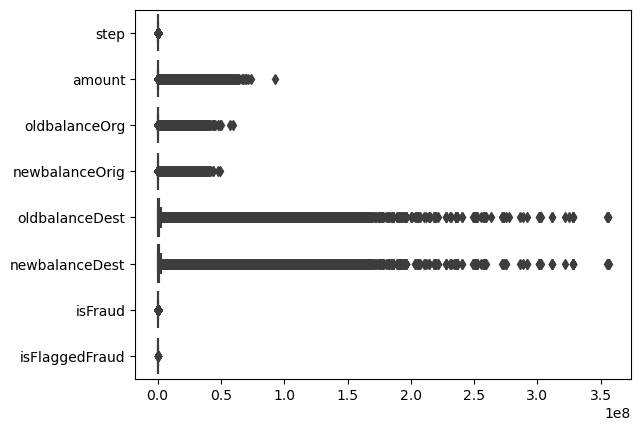

In [ ]:
sns.boxplot(data = df, orient = "h")
plt.show

In [ ]:
df['amount'] = mstats.winsorize(df['amount'], limits=[0.01, 0.01])
df['oldbalanceOrg'] = mstats.winsorize(df['oldbalanceOrg'], limits=[0.01, 0.01])
df['newbalanceOrig'] = mstats.winsorize(df['newbalanceOrig'], limits=[0.01, 0.01])
df['oldbalanceDest'] = mstats.winsorize(df['oldbalanceDest'], limits=[0.01, 0.01])
df['newbalanceDest'] = mstats.winsorize(df['newbalanceDest'], limits=[0.01, 0.01])

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

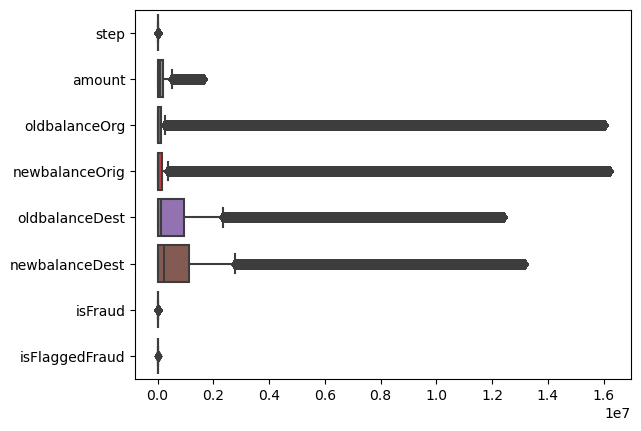

In [ ]:
sns.boxplot(data =df,orient ="h")
plt.plot

In [ ]:
df['log_amount'] = np.log1p(df['amount'])  # log1p(x) = log(1 + x)
df['log_oldbalanceOrg'] = np.log1p(df['oldbalanceOrg'])
df['log_newbalanceOrig'] = np.log1p(df['newbalanceOrig'])
df['log_oldbalanceDest'] = np.log1p(df['oldbalanceDest'])
df['log_newbalanceDest'] = np.log1p(df['newbalanceDest'])

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

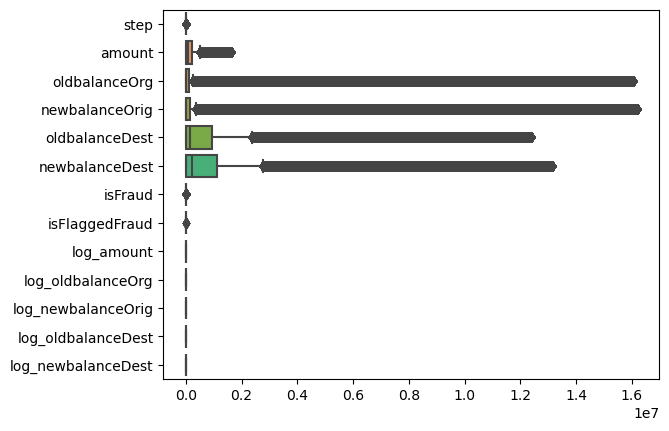

In [ ]:
sns.boxplot(data =df,orient ="h")
plt.plot

In [ ]:
df.drop(['nameOrig','nameDest','amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest','newbalanceDest'], axis=1, inplace=True)

In [ ]:
df

,step,type,isFraud,isFlaggedFraud,log_amount,log_oldbalanceOrg,log_newbalanceOrig,log_oldbalanceDest,log_newbalanceDest
0,1,PAYMENT,0,0,9.194276,12.044359,11.984786,0.000000,0.000000
1,1,PAYMENT,0,0,7.531166,9.964112,9.872292,0.000000,0.000000
2,1,TRANSFER,1,0,6.110269,5.204007,0.000000,0.000000,0.000000
3,1,CASH_OUT,1,0,6.110269,5.204007,0.000000,9.960954,0.000000
4,1,PAYMENT,0,0,9.364703,10.634773,10.305174,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,1,0,12.735768,12.735768,0.000000,0.000000,12.735768
6362616,743,TRANSFER,1,0,14.295455,15.657870,0.000000,0.000000,0.000000
6362617,743,CASH_OUT,1,0,14.295455,15.657870,0.000000,11.134441,15.668663
6362618,743,TRANSFER,1,0,13.652996,13.652996,0.000000,0.000000,0.000000


In [ ]:
label_encoder = preprocessing.LabelEncoder()
df["type"] = label_encoder.fit_transform(df["type"])

***MODEL BUILDING***

*   Feature and Target Selection
*   Data Splitting
*   Handling Class Imbalance
*   Model Instantiation
*   Model Training
*   Making Predictions
*   Model Evaluation



In [ ]:
X = df[['step', 'type', 'log_amount', 'log_oldbalanceOrg', 'log_newbalanceOrig', 'log_oldbalanceDest', 'log_newbalanceDest']]
y = df['isFraud']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print(f"Before SMOTE: {y_train.value_counts()}")
print(f"After SMOTE: {y_train_res.value_counts()}")

Before SMOTE: isFraud
0    4448056
1       5778
Name: count, dtype: int64
After SMOTE: isFraud
0    4448056
1    4448056
Name: count, dtype: int64


In [ ]:
undersampler = RandomUnderSampler(random_state=42)

X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

print("Original class distribution:", y_train.value_counts())
print("Resampled class distribution:", y_resampled.value_counts())

Original class distribution: isFraud
0    4448056
1       5778
Name: count, dtype: int64
Resampled class distribution: isFraud
0    5778
1    5778
Name: count, dtype: int64


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.98      0.78      0.87      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.89      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786

AUC-ROC Score: 0.8921858471657027


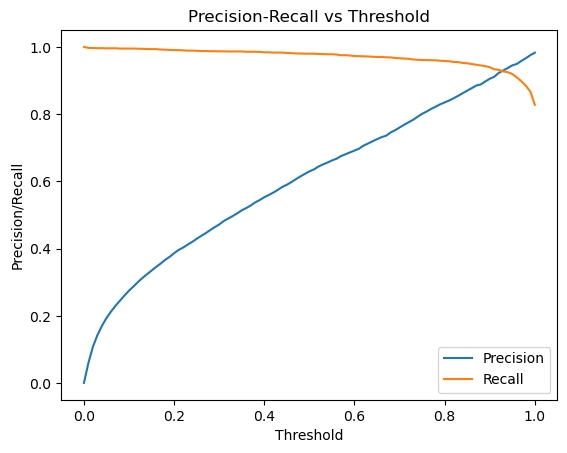

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.76      0.97      0.85      2435

    accuracy                           1.00   1908786
   macro avg       0.88      0.98      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786

AUC-ROC Score: 0.9984688678216431


In [ ]:
y_pred_proba = rf.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.title('Precision-Recall vs Threshold')
plt.show()

y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

print(classification_report(y_test, y_pred_optimal))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))


In [ ]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                    n_iter=10, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2,
                                    random_state=42)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test AUC Score:", roc_auc_score(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}
Best Score: 0.9991938230296403
Test AUC Score: 0.8784305074910324


**Hyper Tuning**

In [ ]:
best_params = {
    'n_estimators': 100,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 20,
    'bootstrap': True
}

rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    bootstrap=best_params['bootstrap'],
    random_state=42
)

rf.fit(X_train, y_train)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC Score: {test_auc}")

y_pred = rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Test AUC Score: 0.9985722450622219
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.98      0.76      0.85      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.88      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='sqrt',
    max_depth=20,
    bootstrap=True,
    random_state=42
)

rf.fit(X_resampled, y_resampled)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC Score: {test_auc}")
y_pred = (y_pred_proba >= 0.3).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))

Test AUC Score: 0.9986207960563147
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906351
           1       0.20      0.99      0.33      2435

    accuracy                           0.99   1908786
   macro avg       0.60      0.99      0.66   1908786
weighted avg       1.00      0.99      1.00   1908786



In [ ]:
best_params = {
    'n_estimators': 100,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 20,
    'bootstrap': True,
    'class_weight': 'balanced'
}

rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    bootstrap=best_params['bootstrap'],
    class_weight=best_params['class_weight'],
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_proba = rf.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC Score: {test_auc}")

y_pred = (y_pred_proba >= threshold).astype(int)

print("Classification Report:\n", classification_report(y_test, y_pred))

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

print(f"Selected threshold: {threshold}")
print(f"Precision at threshold: {precision}")
print(f"Recall at threshold: {recall}")

Test AUC Score: 0.9980544074302882
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.35      0.96      0.51      2435

    accuracy                           1.00   1908786
   macro avg       0.67      0.98      0.76   1908786
weighted avg       1.00      1.00      1.00   1908786

Selected threshold: 0.3
Precision at threshold: [0.00127568 0.01060507 0.01251669 ... 1.         1.         1.        ]
Recall at threshold: [1.         0.99712526 0.99712526 ... 0.01971253 0.01190965 0.        ]


**Feature Importance Calculation**

step: 0.08420672208181038
type: 0.17589011956775
log_amount: 0.17865966805089822
log_oldbalanceOrg: 0.3021448430649724
log_newbalanceOrig: 0.1508045030373736
log_oldbalanceDest: 0.039951986028709564
log_newbalanceDest: 0.06834215816848586


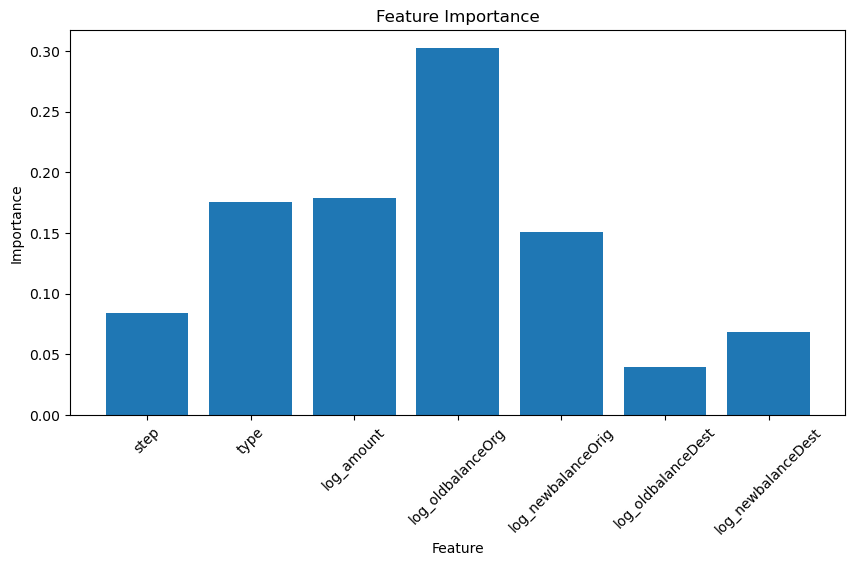

In [ ]:
importances = rf.feature_importances_

for i in range(len(X.columns)):
    print(f"{X.columns[i]}: {importances[i]}")

plt.figure(figsize=(10, 5))
plt.bar(X.columns, importances)
plt.xticks(rotation=45)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

**Correlation** **Analysis**

In [ ]:
correlation = df.corr()
print("Correlation Matrix:\n", correlation)
highly_correlated = correlation[(correlation >= 0.8) & (correlation != 1)]

if highly_correlated.empty:
    print("No highly correlated features found (threshold: 0.8).")
else:
    print("Highly Correlated Features (threshold: 0.8):")
    for col1, col2 in highly_correlated.stack().items():
        print(f"{col1} - {col2}")

Correlation Matrix:
                         step      type   isFraud  isFlaggedFraud  log_amount  \
step                1.000000  0.006635  0.031578        0.003277    0.005701   
type                0.006635  1.000000  0.020833        0.002685   -0.388782   
isFraud             0.031578  0.020833  1.000000        0.044109    0.037480   
isFlaggedFraud      0.003277  0.002685  0.044109        1.000000    0.002858   
log_amount          0.005701 -0.388782  0.037480        0.002858    1.000000   
log_oldbalanceOrg   0.002022 -0.315225  0.034577        0.002211    0.043122   
log_newbalanceOrig -0.007686 -0.372425 -0.028777        0.002495   -0.107090   
log_oldbalanceDest -0.009298 -0.546068 -0.017286       -0.001815    0.620055   
log_newbalanceDest -0.003116 -0.516950 -0.007657       -0.001980    0.692780   

                    log_oldbalanceOrg  log_newbalanceOrig  log_oldbalanceDest  \
step                         0.002022           -0.007686           -0.009298   
type            

**Variance Inflation Factor (VIF) Calculation**

In [ ]:
correlation = df.corr()

highly_correlated = correlation[(correlation >= 0.8) & (correlation != 1)]

if highly_correlated.empty:
    print("No highly correlated features found (threshold: 0.8).")
else:
    print("Highly Correlated Features (threshold: 0.8):")
    for col1, col2 in highly_correlated.stack().items():
        print(f"{col1} - {col2}")

def calculate_vif(X):
    vif = pd.DataFrame()
    vif["variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif = calculate_vif(df[['log_oldbalanceDest', 'log_newbalanceDest']])
print("VIF:\n", vif)


Highly Correlated Features (threshold: 0.8):
('log_oldbalanceDest', 'log_newbalanceDest') - 0.8770667961097685
('log_newbalanceDest', 'log_oldbalanceDest') - 0.8770667961097685
VIF:
              variable       VIF
0  log_oldbalanceDest  9.971485
1  log_newbalanceDest  9.971485


In [ ]:
correlation_oldbalance = df['log_oldbalanceDest'].corr(df['isFraud'])
correlation_newbalance = df['log_newbalanceDest'].corr(df['isFraud'])

print(f"Correlation of log_oldbalanceDest with target: {correlation_oldbalance}")
print(f"Correlation of log_newbalanceDest with target: {correlation_newbalance}")

Correlation of log_oldbalanceDest with target: -0.017286144017123577
Correlation of log_newbalanceDest with target: -0.007656571981853159


In [ ]:
sm = SMOTE(random_state=42)
X_train, y_trains = sm.fit_resample(X_train, y_train)
print(f"Before SMOTE: {y_train.value_counts()}")
print(f"After SMOTE: {y_train_res.value_counts()}")

In [ ]:
df.drop(columns=['log_oldbalanceDest'],axis=1, inplace=True)

In [ ]:
features_to_scale = ['step', 'type', 'log_amount', 'log_oldbalanceOrg', 'log_newbalanceOrig']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features_to_scale])
df_scaled = pd.DataFrame(scaled_features, columns=features_to_scale)
print(df_scaled.head())

       step      type  log_amount  log_oldbalanceOrg  log_newbalanceOrig
0 -1.703042  0.952399   -0.932794           0.817700            1.046831
1 -1.703042  0.952399   -1.872904           0.450507            0.712849
2 -1.703042  1.693076   -2.676099          -0.389717           -0.847946
3 -1.703042 -0.528954   -2.676099          -0.389717           -0.847946
4 -1.703042  0.952399   -0.836456           0.568888            0.781287


In [ ]:
X = df[['step', 'type', 'log_amount', 'log_oldbalanceOrg', 'log_newbalanceOrig']]
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
best_params = {
    'n_estimators': 100,
    'min_samples_split': 2,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 20,
    'bootstrap': True
}

rf_classifier = RandomForestClassifier(**best_params)


In [ ]:
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=4)

In [ ]:
y_pred = rf_classifier.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.94      0.72      0.82      1620

    accuracy                           1.00   1272524
   macro avg       0.97      0.86      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524

AUC-ROC Score: 0.8595391815200969



***Hyperparameter Tuning and Performance Evaluation of XGBoost for Fraud Detection***

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 5]  # Helps with class imbalance
}

In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [ ]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:09:16] WARNING: D:\bld\xgboost-split_1724807710452\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300, 500],
                                        'scale_pos_weight': [1, 2, 5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [ ]:
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)

Best Parameters: {'subsample': 1.0, 'scale_pos_weight': 5, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Accuracy: 0.9996078659420176
Precision: 0.7960908610670893
Recall: 0.9302469135802469
F1-score: 0.8579561628237974
AUC-ROC: 0.964971596382099
